In [28]:
import pandas as pd
import jieba
import jieba.analyse as analyse
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool1D, Conv1D
from keras.layers.embeddings import Embedding
from keras.utils import multi_gpu_model
from keras.models import load_model
from keras import regularizers  # 正则化
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.layers import BatchNormalization


In [29]:
job_detail_pd = pd.read_csv('job_detail_dataset.csv', encoding='UTF-8')
label = list(job_detail_pd['PositionType'].unique())  # 标签
print(label)

FileNotFoundError: File b'job_detail_dataset.csv' does not exist

In [5]:
# 上标签
def label_dataset(row):
    num_label = label.index(row) 
    return num_label

job_detail_pd['label'] = job_detail_pd['PositionType'].apply(label_dataset)
job_detail_pd = job_detail_pd.dropna()  # 删除空行
job_detail_pd.head(5)

,PositionType,Job_Description,label
0,项目管理,"\r\n 岗位职责： \r\n 1 、熟练使用 axure,visio ，熟悉竞品分析，...",0
1,项目管理,"\r\n 岗位职责： \r\n 1 、熟练使用 axure,visio ，熟悉竞品分析，...",0
2,移动开发,\r\n 岗位职责： \r\n 1.负责安卓客户端应用的框架设计； \r\n 2.负责安卓客...,1
3,移动开发,\r\n 现诚招资深iOS高级软件开发工程师一枚！ 【你的工作职责】 1、负责iPhone手...,1
4,后端开发,\r\n 岗位职责： \r\n 1、基于海量交通信息数据的数据仓库建设、数据应用开发。 2、...,2


In [6]:
# 中文分词
def chinese_word_cut(row):
    return " ".join(jieba.cut(row))

job_detail_pd['Job_Description_jieba_cut'] = job_detail_pd.Job_Description.apply(chinese_word_cut)


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.784 seconds.
Prefix dict has been built succesfully.


In [7]:
# 提取关键词
def key_word_extract(texts):
    return " ".join(analyse.extract_tags(texts, topK=50, withWeight=False, allowPOS=()))
job_detail_pd['Job_Description_key_word'] = job_detail_pd.Job_Description.apply(key_word_extract)


# 训练全过程
步骤1：读取数据集；

步骤2：建立token字典；

步骤3：使用token字典将“文字”转化为“数字列表”

步骤4：截长补短让所有“数字列表”长度都是100

步骤5：Embedding层将“数字列表”转化为"向量列表"；

步骤6：将向量列表送入深度学习模型进行训练

In [8]:
# 建立2000个词的字典
token = Tokenizer(num_words = 2000) 
token.fit_on_texts(job_detail_pd['Job_Description_key_word']) #按单词出现次数排序，排序前2000的单词会列入词典中


In [9]:
print(token.document_count)  # 查看token读了多少文章
print(token.word_index)  # 查看token读了多少文章

44831
{'熟悉': 1, '经验': 2, '开发': 3, '优先': 4, '工作': 5, '岗位职责': 6, '能力': 7, '负责': 8, 'java': 9, '以上学历': 10, '技术': 11, '团队': 12, '设计': 13, '精通': 14, 'web': 15, '任职': 16, '相关': 17, 'mysql': 18, '数据库': 19, '熟练': 20, '良好': 21, '沟通': 22, '框架': 23, 'javascript': 24, 'linux': 25, '编写': 26, '编程': 27, '文档': 28, '产品': 29, '项目': 30, '优化': 31, '系统': 32, 'css': 33, '以上': 34, '熟练掌握': 35, 'html': 36, '架构': 37, '平台': 38, '代码': 39, '责任心': 40, '要求': 41, '具备': 42, 'c': 43, 'jquery': 44, '测试': 45, 'sql': 46, '应用': 47, 'php': 48, '本科': 49, '岗位': 50, '职位': 51, 'android': 52, '使用': 53, '计算机相关': 54, '维护': 55, '软件': 56, '前端': 57, '专业': 58, '完成': 59, 'ajax': 60, '需求': 61, '了解': 62, '具有': 63, 'html5': 64, '流程': 65, '互联网': 66, '分析': 67, 'app': 68, 'oracle': 69, 'ios': 70, '性能': 71, 'js': 72, '模块': 73, 'python': 74, '学习': 75, '架构设计': 76, '设计模式': 77, '语言': 78, '开源': 79, 'spring': 80, '移动': 81, '协作': 82, '参与': 83, '研发': 84, '职责': 85, '计算机': 86, '进行': 87, '常用': 88, '网站': 89, '算法': 90, '公司': 91, '软件开发': 92, '独立': 93, 'htt

In [10]:
# 使用token字典将“文字”转化为“数字列表”
Job_Description_Seq = token.texts_to_sequences(job_detail_pd['Job_Description_key_word'])



In [11]:
# 截长补短让所有“数字列表”长度都是50
Job_Description_Seq_Padding = sequence.pad_sequences(Job_Description_Seq, maxlen=50)

x_train = Job_Description_Seq_Padding
y_train = job_detail_pd['label'].tolist()

## 开始训练CNN

In [24]:

model = Sequential()
model.add(Embedding(output_dim = 32,  # 词向量的维度
                    input_dim = 2000,  # Size of the vocabulary 字典大小
                    input_length = 50  # 每个数字列表的长度
                   )  
         )

model.add(Conv1D(256,  # 输出大小
                 3,   # 卷积核大小
                 padding='same', 
                 activation='relu'))
model.add(MaxPool1D(3,3,padding='same'))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(BatchNormalization()) # (批)规范化层
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 10,
                activation = "softmax"))

batch_size = 256
epochs = 5

# 单GPU版本
model.summary()  # 可视化模型
model.compile(loss = "sparse_categorical_crossentropy",  # 多分类
            optimizer = "adam",
            metrics = ["accuracy"])

history = model.fit(
          x_train, 
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split = 0.2
          # 训练集的20%用作验证集
        )


# 多GPU版本
# """
#                        如果你的 targets 是 one-hot 编码，用 categorical_crossentropy
#                        one-hot 编码：[0, 0, 1], [1, 0, 0], [0, 1, 0]
#                        如果你的 tagets 是 数字编码 ，用 sparse_categorical_crossentropy
#                        数字编码：2, 0, 1
#  """
# parallel_model = multi_gpu_model(model, gpus=2)
# parallel_model.compile(loss='sparse_categorical_crossentropy',  # 多分类     
#                        optimizer='adam',
#                        metrics=['accuracy']
#                       )

# # This `fit` call will be distributed on 4 GPUs.
# # Since the batch size is 50, each GPU will process 32 samples.

# history = parallel_model.fit(
#           x_train, 
#           y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_split = 0.2
#         )

# # 保存模型
# parallel_model.save('model_CNN.h5')  # creates a HDF5 file 'my_model.h5'
# # 模型可视化
# plot_model(model, to_file='model_CNN.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 32)            64000     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 50, 64)            6208      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 17, 32)            6176      
_________________________________________________________________
flatten_6 (Flatten)          (None, 544)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 544)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 544)               2176      
__________

## 保存模型 & 模型可视化

In [20]:
from keras.utils import plot_model
# 保存模型
model.save('model_CNN_text.h5')  # creates a HDF5 file 'my_model.h5'
# 模型可视化
plot_model(model, to_file='model_CNN_text.png', show_shapes=True)

## 模型的预测功能

In [21]:
from keras.models import load_model
# 加载模型
# model = load_model('model_CNN_text.h5')
print(x_train[0])
y_new = model.predict(x_train[0].reshape(1, 50))
print(list(y_new[0]).index(max(y_new[0])))
print(y_train[0])

[   0    0    0    0    0    0    0    0    0    0   66  135  104   29
    4  265    1  200 1842 1170  624    6    2  236  156   62  131   63
   20  153   16   45  863  912   89   38  137  528  353 1691  449  892
    7   30   67  127   41   34   53  205]
0
0


## 训练过程可视化

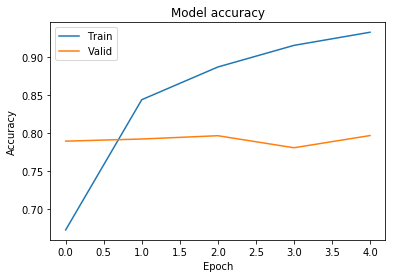

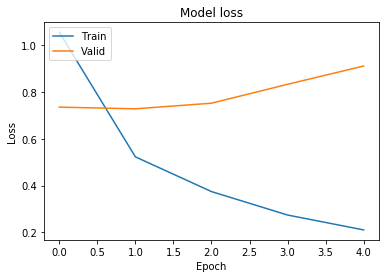

In [25]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('Valid_acc.png')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('Valid_loss.png')
plt.show()